In [30]:
#Importamos las dependencias 
import spacy
import pandas as pd
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [4]:
#Entrada de libro y tokenización del mismo

try:
    nlp = spacy.load("es_core_news_sm")
    nlp.max_length = 2000000
except OSError:
    print("Descargando modelo....")
    from spacy.cli import download
    download("es_core_news_sm")
    nlp = spacy.load("es_core_news_sm")
    nlp.max_length = 2000000

with open("El-Caballo-de-Troya.txt", "r", encoding="utf-8") as f:
    book = f.read()

doc = nlp(book)

In [5]:
#Filtrar Stop Words

tokens_relevantes = []

for token in doc:
     if not token.is_stop and not token.is_punct and token.text.strip():
          tokens_relevantes.append(token.text)

print(f"-----Filtrado de Stop Words-------")
print(f"Palabras que se conservaron:  {tokens_relevantes[:10]}")
print(f"Cantidad de palabras: {len(tokens_relevantes)}")

-----Filtrado de Stop Words-------
Palabras que se conservaron:  ['Caballo', 'Troya', 'J.', 'J.', 'Benítez', 'WASHINGTON', 'reloj', 'señalaba', 'Faltaban', 'horas']
Cantidad de palabras: 117907


In [6]:
#Etapa de Lematización

tokens_normalizados = []
cambios = []

for token in doc:
    if not token.is_stop and not token.is_punct and token.text.strip():

        lema = token.lemma_.lower()
        tokens_normalizados.append(lema)
    
        if token.text.lower() != lema:
            cambios.append(f"{token.text} -> {lema}")

print("-----Lematización y Normalización-------")
print(f"Total de tokens procesados:  {len(tokens_normalizados)}")
print(f"Ejemplos de transformaciones en (Palabra original -> Lema)")
print(cambios[:20])
print(tokens_normalizados[:10])



-----Lematización y Normalización-------
Total de tokens procesados:  117907
Ejemplos de transformaciones en (Palabra original -> Lema)
['señalaba -> señalar', 'Faltaban -> faltar', 'horas -> hora', 'cerrara -> cerrar', 'puertas -> puerta', 'consumido -> consumir', 'tumbas -> tumba', 'soldados -> soldado', 'desconocidos -> desconocido', 'llama -> llamar', 'anaranjada -> anaranjado', 'reposan -> reposar', 'restos -> resto', 'leerla -> leer él', 'terminado -> terminar', 'entregado -> entregar', 'escruté -> escruter', 'levanta -> levantar', 'constituye -> constituir', 'esculpidas -> esculpir']
['caballo', 'troya', 'j.', 'j.', 'benítez', 'washington', 'reloj', 'señalar', 'faltar', 'hora']


In [7]:
#Proceso de Stemming
stemmer = SnowballStemmer("spanish")

data_comparativa = []

for token in doc:

    if not token.is_stop and not token.is_punct:

        raiz_stem = stemmer.stem(token.text)

        lema = token.lemma_

        data_comparativa.append({
            "Original": token.text,
            "Stemming (Corte)" : raiz_stem,
            "Lematización" : lema,
            "Coinciden?": raiz_stem == lema
        })

df = pd.DataFrame(data_comparativa)

print(f"\n -----Lematización vs Stemming-------")

palabras = ["puertas", "consumido", "tumbas", "soldados", "señalaba", "desconocidos"]
filtro = df[df["Original"].isin(palabras)]

print(filtro.to_string(index=False))
print("Primeros 10 ejemplos de Stemming y comparación")
print(df.head(10).to_string(index=False))


 -----Lematización vs Stemming-------
    Original Stemming (Corte) Lematización  Coinciden?
    señalaba            señal      señalar       False
     puertas            puert       puerta       False
   consumido           consum     consumir       False
      tumbas             tumb        tumba       False
    soldados             sold      soldado       False
desconocidos         desconoc  desconocido       False
      tumbas             tumb        tumba       False
    señalaba            señal      señalar       False
     puertas            puert       puerta       False
     puertas            puert       puerta       False
     puertas            puert       puerta       False
    soldados             sold      soldado       False
desconocidos         desconoc  desconocido       False
      tumbas             tumb        tumba       False
      tumbas             tumb        tumba       False
desconocidos         desconoc  desconocido       False
    soldados             s

In [35]:
#Generación del Corpus(Lematizado)

corpus_lematizado = []

for oracion in doc.sents:
    lemma_oracion = [
        token.lemma_.lower()
        for token in oracion
        if not token.is_punct and not token.is_space and not token.is_stop 
    ]

    if lemma_oracion:
        corpus_lematizado.append(" ".join(lemma_oracion))

print(f"Total de oraciones procesadas en el corpus: {len(corpus_lematizado)}")

Total de oraciones procesadas en el corpus: 12153


In [36]:
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(corpus_lematizado)
vocab_bow = bow_vectorizer.get_feature_names_out()

X_bow

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 116930 stored elements and shape (12153, 15869)>

In [37]:
tfidfvectorizer = TfidfVectorizer()
X_tfid = tfidfvectorizer.fit_transform(corpus_lematizado)
vocab_tfidf = tfidfvectorizer.get_feature_names_out()

X_tfid

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 116930 stored elements and shape (12153, 15869)>

In [39]:
from sklearn.manifold import TSNE

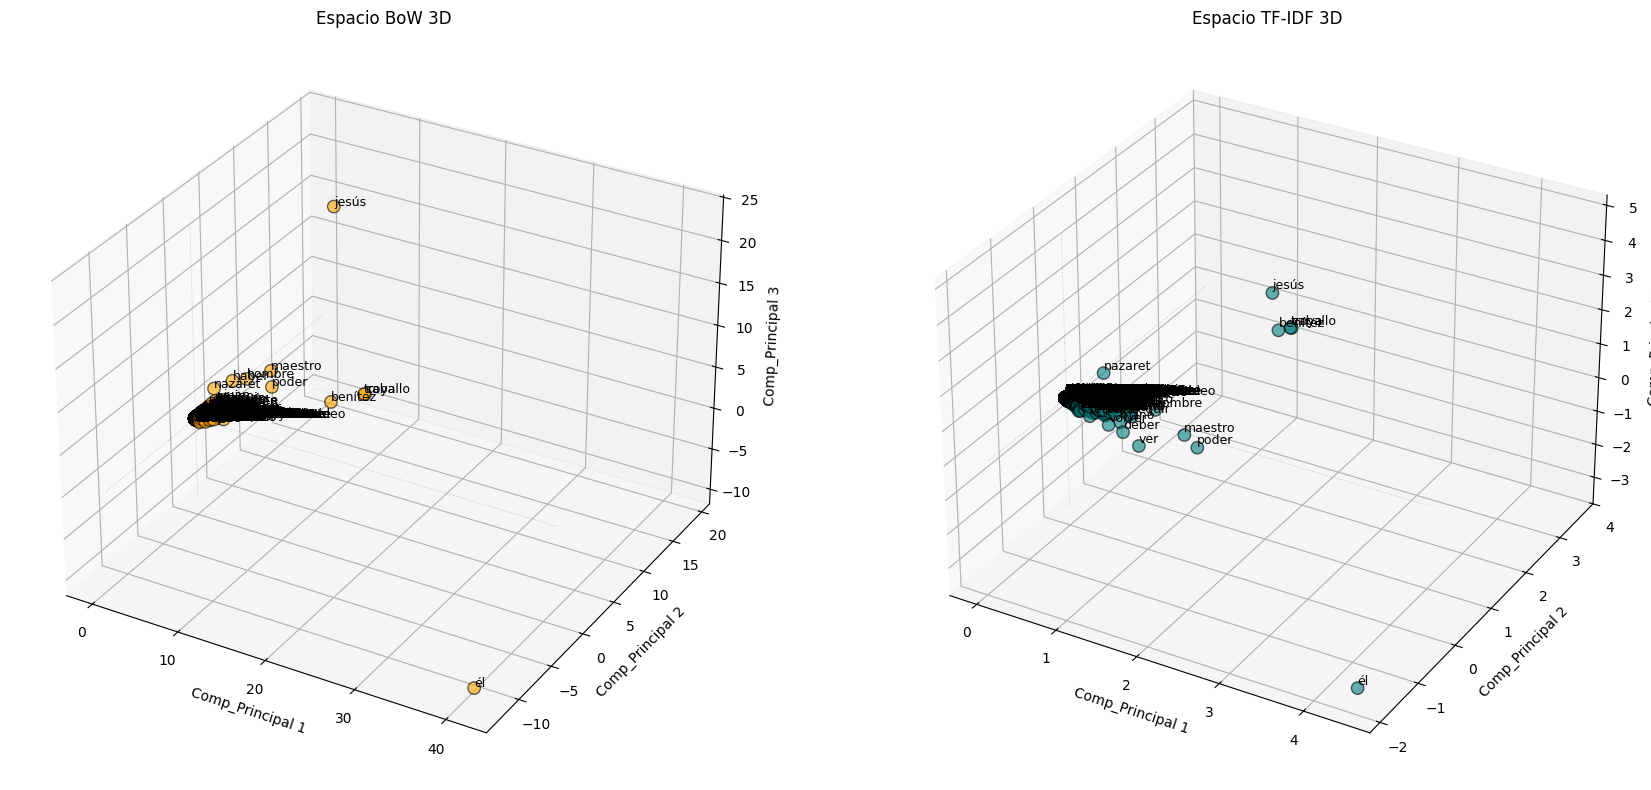

In [42]:
#Reducción de la dimensionalidad del Corpus

#Funcion para la figura en 3d

def graficar_palabras(ax, matriz, vocabulario, titulo, color_puntos):

    matriz_palabras = matriz.T

    pca = PCA(n_components=3)
    coords = pca.fit_transform(matriz_palabras.toarray())

    #tsne = TSNE(n_components=3, perplexity=30.0)
    #coords = tsne.fit_transform(matriz_palabras.toarray())
    
    #Extracción de coordenadas

    x = coords[:, 0]
    y = coords[:, 1]
    z = coords[:, 2]

    ax.scatter(x, y, z, c=color_puntos, s=80, edgecolors='k', alpha=0.6, depthshade=True)

    for i, palabra in enumerate(vocabulario):
        ax.text(x[i], y[i], z[i] + 0.1, palabra, fontsize=9)

    ax.set_title(titulo)
    ax.set_xlabel('Comp_Principal 1')
    ax.set_ylabel('Comp_Principal 2')
    ax.set_zlabel('Comp_Principal 3')

    # Líneas de referencia en el origen (0,0,0)3
    ax.plot([0,0], [0,0], [z.min(), z.max()], c='grey', ls='--', lw=0.5, alpha=0.3)
    ax.plot([x.min(), x.max()], [0,0], [0,0], c='grey', ls='--', lw=0.5, alpha=0.3)
    ax.plot([0,0], [y.min(), y.max()], [0,0], c='grey', ls='--', lw=0.5, alpha=0.3)


fig = plt.figure(figsize=(18, 8))

ax1 = fig.add_subplot(121, projection='3d')


#vocab_bow = bow_vectorizer.get_feature_names_out()

graficar_palabras(ax1, X_bow, vocab_bow, "Espacio BoW 3D", "orange")

ax2 = fig.add_subplot(122, projection='3d')

#vocab_tfidf = tfidfvectorizer.get_feature_names_out()

graficar_palabras(ax2, X_tfid, vocab_tfidf, "Espacio TF-IDF 3D", "teal")

plt.tight_layout()
plt.show()